# Graphs
At its core, `LangGraph` models AI systems as graphs. You define the behaviour of your system using three components:
1. `State`: A shared data structure that represents the current snapshot of our application (typically a `TypedDict` or Pydantic `BaseModel`)
2. `Nodes`: Python functions that encode the logic of our system. They recieve the current `State` as input, perfrom some computation and return the updated `State`.
3. `Edges`: Python functions that determine which `Node` to execute next based on the current `State`. They can be conditional branches or fixed transitions.

By composing `Nodes` and `Edges`, we can create complex, looping workflows that evolve the `State` over time. The real power comes from how LangGraph manages `State`. To emphasize: `Nodes` and `Edges` are nothing more than Python functions. They can contain an LLM or just Python code.

In short: *nodes to the work. edges tell us what to do next.*

LangGraph's underlying graph algorithm uses message passing to define a general program. When a `Node` completes its operation, it sends messages along one or more edges to other node(s). These recipients nodes then execute their functions, pass the resulting messages to the next set of nodes, and the process continues.

The program proceeds in discrete "super-steps".

- A super-step can be considered a single iteration over the graph nodes. 
- Nodes that run in parallel are part of the same super step, while nodes that run sequentially belong to separate super steps.
- At the start of graph execution all nodes begin in an `inactive` state. A node becomes `active` when it receives a new message (state) on any of its incoming edges (or "channels").
- The active node then runs it function and responds with updates


### `StateGraph`
The `StateGraph` class is the main graph class. It is prarameterized by a user defined `State` object. 

**Compiling Graphs**

You MUST compile your graph before you can use it.


To build a graph, we frist define the `state`, then add `nodes` and `edges`, and then we compile it. What exactly is compiling your graph and why is it needed?

- compiling provides a few basic checks on the structure of our graph (no orphaned nodes, etc.)
- it is also where we specify runtime args like `checkpointers` and `breakpoints`


## Pydantic
`TypedDicted` and `dataclasses` provide type hints but they don't enforce types at runtime. This means that we can potentially assign invalid valaues without raises an error.

Pydantic is a data validation library using Python type  annotations. Its particularly well suited for defining state schemas in LangGraph due to its validation capabilities.

Pydantic can perfrom validation to check whether data conform to the specific types and constrants at runtime.


In [5]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    result: str # "passed" or "failed"

    @field_validator('result')
    @classmethod
    def validate_mood(cls, value):
        if value not in ['success', 'failure']:
            raise ValueError("Each result must be either 'happy' or 'sad'")

In [6]:
try: 
    state = PydanticState(name='Script-1', result='undefined')
except ValidationError as e:
    print(e)

1 validation error for PydanticState
result
  Value error, Each result must be either 'happy' or 'sad' [type=value_error, input_value='undefined', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


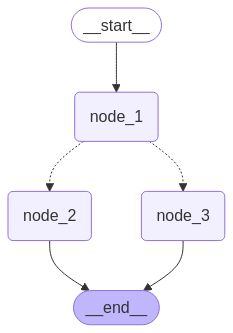

In [7]:
import random
from typing_extensions import TypedDict
from typing import Literal

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " result is... "}

def node_2(state):
    print("---Node 2---")
    return {"result": "success"}

def node_3(state):
    print("---Node 3---")
    return {"result": "failure"}

def decide_result(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)


# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_result)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke(PydanticState(name="Script-1",result="success"))

---Node 1---
---Node 2---


{'name': 'Script-1 result is... ', 'result': 'success'}

# Reducers
Now that we have covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic` or `dataclasses`, now we can dive into **reducers**, which specify how state updates are performed on specific keys/ channels in the state schema.

Reducers are key to understanding how to updates from nodes are applied to the `State`. Each key in the `State` has its own independent reducer function. If no reducer functon is explicitly specified then its assumed that all updates to they key should over ride it =. 

There are a few different types of reducers, starting with the default type of reducer:

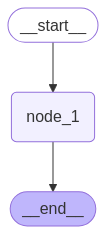

In [22]:
from typing_extensions import TypedDict
from langgraph.graph import MessagesState


class State(TypedDict):
    foo: int
    bar: list[str]

def node_1(state):
    return {"foo": [state['foo'][0] + 1], "bar": ['bye']}
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"foo" : [1], 'bar': ['Hi']})

{'foo': [2], 'bar': ['HI']}

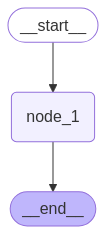

In [23]:
from typing_extensions import TypedDict
from langgraph.graph import MessagesState


class State(TypedDict):
    foo: Annotated[list[int], add]
    bar: Annotated[list[str], add]

def node_1(state):
    return {"foo": [state['foo'][0] + 1], "bar": ['bye']}
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
graph.invoke({"foo" : [1], 'bar': ['Hi']})

{'foo': [1, 2], 'bar': ['Hi', 'bye']}

We can use `Annotated` type to specify a reducer function (`operator.add`). 

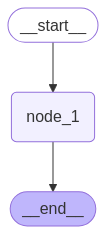

In [16]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    return {"foo": [state['foo'][0] + 1]}
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"foo" : [1]})

{'foo': [1, 2]}

Now our state key `foo` is a list. This `operator.add` reducer function will append updates from each node to this list.

### Multiple Schema



Typically all graph nodes communicate with a single schema. This means they will read and write to the same static channels. But there are cases where we want more control over this:

1. Internal nodes can pass information that is not required in the graph's input/output
2. we may also want to use different input/output schemas for graphs. The output might only contain a single relevant output key. 


### Private State

In some cases, we may want nodes to exchange information that is crucial for intermediate logic but doesn't need to be part of the main schema of the graph. This private data is not relevant to the overall input/output of the graph and should be shared between certain nodes.

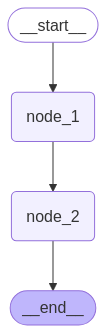

In [9]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int


def node_1(state: OverallState) -> PrivateState:
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)


# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"foo" : 1})

{'foo': 3}

# Input/Output schema

By default, `StateGraph` operates with a single schema, and all nodes are expected to communicate using that schema. However, its also possible to define input and output schemas for a graph.

When distinct schemas are specified, an interal schema will still be used for communication between nodes. The input schema ensures that the provided input matches the expected structure, while the output schema filters the interal data to return only the relevant informtion according to the defined output schema.

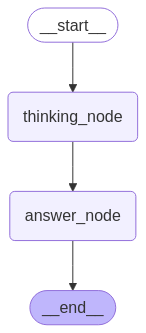

{'answer': 'bye Lance'}

In [11]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str


def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

In [13]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# ── Public input: what a user must supply to run the graph
class InputState(TypedDict):
    raw_sas_code: str

# ── Private-only state: intermediate data not exposed at the end
class AstState(TypedDict):
    ast: dict

class ExplanationState(TypedDict):
    explanation: str

# ── Public output: what the graph returns to the caller
class OutputState(TypedDict):
    python_code: str

# ── Internal union: lets every node see both public and private keys
class OverallState(TypedDict):
    raw_sas_code: str
    ast: dict
    explanation: str
    python_code: str

### Parsing the SAS into an AST
- This function reads raw_sas_code and writes a new key, ast.
- Later nodes can inspect ast but it never appears in the final output

In [14]:
def parseSasNode(state: InputState) -> AstState:
    # Take the raw SAS string and produce an AST dictionary.
    sas_text = state["raw_sas_code"]
    # Here you’d call your SAS parser library.
    # We simulate by constructing a simple dict:
    ast_dict = {
        "procedure": "PRINT",
        "data": "mydata",
        "variables": ["x", "y"]
    }
    return {"ast": ast_dict}

### Explaining the AST with an LLM

In [15]:
def explainAstNode(state: AstState) -> ExplanationState:
    # Simulate calling an LLM to describe the AST’s intent.
    ast = state["ast"]
    explanation_text = (
        f"This AST indicates a PRINT procedure on table '{ast['data']}', "
        f"selecting columns {ast['variables']}."
    )
    return {"explanation": explanation_text}

In [17]:
def generatePythonNode(state: OverallState) -> OutputState:
    # Simulate an LLM generating Python code based on the AST.
    ast = state["ast"]
    # In a real system, you’d include ast and maybe explanation in your prompt.
    python_snippet = f"print(df[{ast['variables']}])"
    return {"python_code": python_snippet}

In [18]:
# Construct the graph with explicit public I/O
graph = StateGraph(
    OverallState,       # union of all keys
    input=InputState,   # only raw_sas_code accepted
    output=OutputState  # only python_code returned
)

# Add our three nodes in sequence
graph.add_node("parseSas",      parseSasNode)
graph.add_node("explainAst",    explainAstNode)
graph.add_node("generatePython", generatePythonNode)

# Wire up the flow
graph.add_edge(START,          "parseSas")
graph.add_edge("parseSas",     "explainAst")
graph.add_edge("explainAst",   "generatePython")
graph.add_edge("generatePython", END)

# Compile and invoke
graph = graph.compile()
result = graph.invoke({
    "raw_sas_code": "proc print data=mydata; var x y; run;"
})
print(result)
# Expected output: {'python_code': "print(df[['x', 'y']])"}

{'python_code': "print(df[['x', 'y']])"}


- private keys exist on the internal graph state but are filtered out at the boundary thanks to the output schema.
- It’s easy to miss that if you specify input/output schemas, only the START node uses the input schema and each node either uses its own declared schema or falls back to the internal schema.

# Streaming
There are three main types of data we'll want to stream:
1. Workflow progress (e.g., get state updates after each graph node is executed)
2. LLM tokens as they're generated.
3. Custom Update (e.g., Fetched 10/100 records").

`.stream` and `.astream` are sync and async methods for streaming back outputs from a graph run. There are several modes we can specify when calling these methods 

# Breakpoints
For `human-in-the-loop`, we often want to see our graph outputs as its running. Streaming allows us to do that (will be covered)

There are a few motivations for human-in-the-loop for AI systems:
1. Approval - we can interrupt our agent, surface the state to a user, allow the user to accept an action
2. Debugging - We can rewind the graph to reproduce or avoid issues
3. Editing - You can modify the state

First, lets go over the concept of breakpoints, which provide a simple way to stop the graph at specific steps. This will allow us to enable user `approval`.

#### Break points for human approval

Lets re-consider a very simple agent. Assume we are concerned with tool use: we want to approve the agent to use any of its tools. All we need to do is simply compile the graph with `interrupt_before=["tools"]`, where `tools` is our tools node. This means that the execution will be interrupted before the node `tools`, which executes the tool call. 

In [20]:
import os
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, END


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]

llm = AzureChatOpenAI(
    azure_deployment= os.environ["AZURE_OPENAI_DEPLOYMENT"],
    api_version= os.environ["AZURE_OPENAI_API_VERSION"],
)

llm_with_tools = llm.bind_tools(tools)

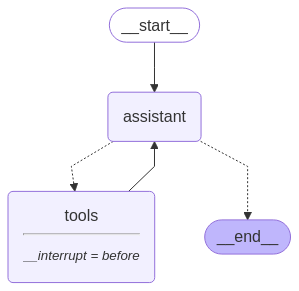

In [23]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage



# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)


# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")


memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)


# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [24]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ecoMQIqshsJ8vizPbbOO4RTt)
 Call ID: call_ecoMQIqshsJ8vizPbbOO4RTt
  Args:
    a: 2
    b: 3


In [25]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_ecoMQIqshsJ8vizPbbOO4RTt)
 Call ID: call_ecoMQIqshsJ8vizPbbOO4RTt
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


Now, lets bring these together with a specific user approval step that accepts user input.

In [28]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rLR4dtY3GBo8QQXeaFk4yzmS)
 Call ID: call_rLR4dtY3GBo8QQXeaFk4yzmS
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  no


Operation cancelled by user.


In [30]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_AojDBiJNVTWHlhZ7Ug8TP1wk)
 Call ID: call_AojDBiJNVTWHlhZ7Ug8TP1wk
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  YES


================================== Ai Message ==================================
Tool Calls:
  multiply (call_AojDBiJNVTWHlhZ7Ug8TP1wk)
 Call ID: call_AojDBiJNVTWHlhZ7Ug8TP1wk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Editing
Now lets directly edit the graphs state and insert human feedback. **Breakpoints allow us to interrupt graph execution before a specific step**. At this breakpoint, we can manually edit the graph state and then resume from that spot to continue. 


In [41]:

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show

In [42]:


# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3


We can see the graph is interrupted before the chat model responds.

In [43]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='2691e13b-9d09-45b6-ba8c-74940f110145')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f026375-4b53-6da0-8000-66d9f890edf7'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-01T02:52:33.470589+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f026375-4b50-63f8-bfff-4b7c7cf135f8'}}, tasks=(PregelTask(id='bce23f4b-2574-fd1e-c7b3-be7922a2aedc', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:
- if we want to over-write the exisiting message, we can supply the message `id`
- if we simply want to append to our list of messages, we can pass a message without an `id`


In [44]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f026375-8d37-6eb0-8001-7ce12d5a8ecd'}}

We called `update_state` with a new message. We called update_state with a new message.

In [46]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed by simply by passing `None` and allowing it proceed from the current state. We emit the current and then proceed to execute the remaining nodes.




In [47]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_k3al3qQuuiJ8TojCBWPYhr1Z)
 Call ID: call_k3al3qQuuiJ8TojCBWPYhr1Z
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [48]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


## Awaiting user input
So, it's clear that we can edit our agent state after a breakpoint. Now, what if we want to allow for human feedback to perform this state update?
- We'll add a node that serves as a placeholder for human feedback within our agent.
- This `human_feedback` node allow the user to add feedback directly to state.''
We specify the breakpoint using `interrupt_before` our `human_feedback` node.


We set up a checkpointer to save the state of the graph up until this node.

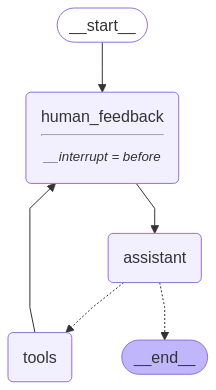

In [53]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

We use `.update_state` to update the state of the graph with the human response we get, as before.
We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

In [56]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}


# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")


# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


Tell me how you want to update the state:  no, multiply 3 and 3


================================ Human Message =================================

no, multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KJjRvNPTMkonPnP4C9chSXDq)
 Call ID: call_KJjRvNPTMkonPnP4C9chSXDq
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [57]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9. Would you like to perform any additional operations with this result?


# Dynamic breakpoints
Breakpoints are set by the developer on a specific node during graph compilation. But, sometimes it is helpful to allow the graph dynamically interrupt itself! This is an internal breakpoint, and can be achieved using `NodeInterrupt`.


This has a few specific benefits:

1. you can do it conditionally (from inside a node based on developer-defined logic).

2. you can communicate to the user why its interrupted (by passing whatever you want to the NodeInterrupt).

Let's create a graph where a NodeInterrupt is thrown based upon length of the input.


# Time travel
Now, let's look at how LangGraph supports debugging by viewing, re-playing, and even forking from past states.
This is called: `time travel`.


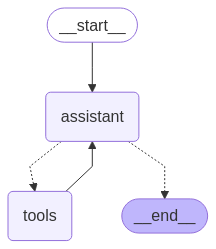

In [58]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [61]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "7"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tPU9Cs2wm0wnsBTg2BV5Dm11)
 Call ID: call_tPU9Cs2wm0wnsBTg2BV5Dm11
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.



#### Browsing History
We can use `get_state` to look at the current state of our graph, given the `thread_id`!

In [63]:
graph.get_state({'configurable': {'thread_id': '7'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='1d86ed30-5c69-4cff-bf98-91d5f1caaf28'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tPU9Cs2wm0wnsBTg2BV5Dm11', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 134, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_ded0d14823', 'id': 'chatcmpl-BSF7ykPWZWub6S5CxJlDmaPtZFx84', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': 

We can also browse the state history of our graph. `get_state_history` lets us get the state at all prior steps.

In [65]:
all_states = [s for s in graph.get_state_history(thread)]

In [66]:
len(all_states)

5